# The final model
 

## Model v2.1

In [1]:
model_name = f'3.31-v2.1'

In [2]:
import warnings

from sklearn.metrics import root_mean_squared_error

warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
from data import load_data

_, augmented_data, test_data = load_data()

In [4]:
augmented_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 168588 entries, p01_test_12 to p24_test_94938
Columns: 507 entries, p_num to bg+1:00
dtypes: float64(433), object(74)
memory usage: 657.4+ MB


In [5]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3644 entries, p01_8459 to p24_260
Columns: 506 entries, p_num to activity-0:00
dtypes: float64(432), object(74)
memory usage: 14.2+ MB


# Prepare the data

In [6]:
from pipelines import pipeline

train_data_transformed = pipeline.fit_transform(augmented_data)

X_train = train_data_transformed.drop(columns=['bg+1:00'])
y_train = train_data_transformed['bg+1:00']

## Predict for validation data and check results

In [7]:
import dnns
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasRegressor

create_dnn_model = dnns.create_model_MA01I


def model_with_pretrained_weights():
    dnn = create_dnn_model(X_train.shape[1])
    dnn.load_weights(f'{model_name}.weights.h5')  # Load the pre-trained weights

    # Freeze all layers except the last one (optional)
    for layer in dnn.layers:
        layer.trainable = False
    # Unfreeze the output layer if you want to fine-tune it
    # dnn.layers[-1].trainable = True

    dnn.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=[dnns.rmse]
    )
    return dnn


Epoch 1/100
4215/4215 - 4s - 959us/step - loss: 9.7221 - rmse: 2.9160 - val_loss: 5.6989 - val_rmse: 2.1010
Epoch 2/100
4215/4215 - 3s - 807us/step - loss: 6.2829 - rmse: 2.4525 - val_loss: 5.5145 - val_rmse: 2.0809
Epoch 3/100
4215/4215 - 3s - 740us/step - loss: 5.4605 - rmse: 2.2961 - val_loss: 5.6771 - val_rmse: 2.0989
Epoch 4/100
4215/4215 - 3s - 719us/step - loss: 5.0986 - rmse: 2.2183 - val_loss: 5.4473 - val_rmse: 2.0636
Epoch 5/100
4215/4215 - 3s - 711us/step - loss: 4.8502 - rmse: 2.1626 - val_loss: 5.2547 - val_rmse: 2.0343
Epoch 6/100
4215/4215 - 3s - 789us/step - loss: 4.6899 - rmse: 2.1258 - val_loss: 5.1308 - val_rmse: 2.0323
Epoch 7/100
4215/4215 - 3s - 697us/step - loss: 4.6138 - rmse: 2.1088 - val_loss: 5.1147 - val_rmse: 2.0084
Epoch 8/100
4215/4215 - 3s - 784us/step - loss: 4.5676 - rmse: 2.0958 - val_loss: 5.1711 - val_rmse: 2.0241
Epoch 9/100
4215/4215 - 3s - 684us/step - loss: 4.5255 - rmse: 2.0858 - val_loss: 5.1388 - val_rmse: 2.0306
Epoch 10/100
4215/4215 - 3s 

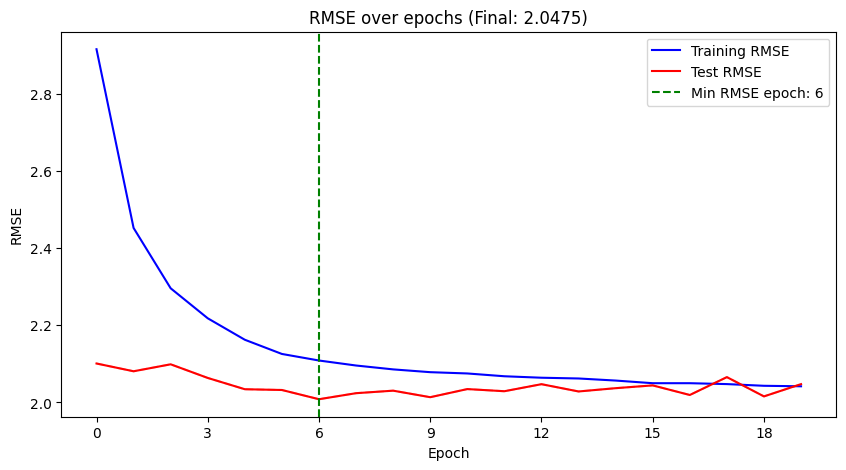

In [8]:
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import StackingRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import LassoLarsIC, Ridge
from tensorflow.keras.callbacks import EarlyStopping
from model_performance_calculations import get_history_line_chart

hgb_estimator = HistGradientBoostingRegressor(
    max_depth=4,
    learning_rate=0.05,
    max_iter=500,
    min_samples_leaf=20,
    early_stopping='auto',
    validation_fraction=0.1,
    n_iter_no_change=10,
    verbose=0
)

lasso_lars_ic_base_model = LassoLarsIC(
    criterion='aic',
    eps=0.03922948513965659,
    max_iter=1944,
    noise_variance=5.4116687755186035e-05,
    positive=False,
)

knn_base_estimator = KNeighborsRegressor(
    leaf_size=30,
    metric='minkowski',
    n_neighbors=7,
    p=2,
    weights='distance'
)

xgb_base_estimator = XGBRegressor(
    n_estimators=1000,
    max_depth=5,
    learning_rate=0.01,
    colsample_bytree=0.8,
    subsample=0.8,
    objective='reg:squarederror',
    random_state=42,
)

# pretrain the DNN and use the weights in the stacking model
pretrained_dnn = create_dnn_model(X_train.shape[1])
pretrained_dnn.fit(
    X_train,
    y_train,
    epochs=100,
    verbose=2,
    validation_split=0.2,
    batch_size=32,
    callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
)

history = pretrained_dnn.history.history
pretrained_dnn.save_weights(f'{model_name}.weights.h5')

keras_regressor = KerasRegressor(
    model=model_with_pretrained_weights,
    epochs=1,
    verbose=2
)

estimators = [
    ('hgb', hgb_estimator),
    ('lasso_lars_ic', lasso_lars_ic_base_model),
    ('knn', knn_base_estimator),
    ('xgb', xgb_base_estimator),
    ('dnn', keras_regressor)
]

model = StackingRegressor(estimators=estimators, final_estimator=Ridge(alpha=0.1), n_jobs=1, verbose=2)

get_history_line_chart([history]).show()

In [ ]:
from datetime import datetime
import os
from model_performance_calculations import calculate_stacking_regressor_performance, get_rmse_boxplot_chart, get_rmse_line_chart, save_performances, save_model

date_time = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

save_model(model, os.path.join('models', f'{model_name}.pkl'))

performances = calculate_stacking_regressor_performance(model, X_train, y_train, n_splits=10)
save_performances(performances, os.path.join('models', f'{model_name}-performances.json'))

get_rmse_boxplot_chart(performances).show()
get_rmse_line_chart(performances).show()

10:31:48 - Start training
10:31:48 - Calculate performance for hgb
10:31:48 - Split 1 - Model: hgb
10:31:48 - Fitting the model
10:32:06 - Predicting
10:32:07 - Calculating scores
10:32:07 - R^2: 0.6168986956161264, RMSE: 2.036752588683351, MAE: 1.5196064230713495, MSE: 4.148361107508331
10:32:07 - Split 2 - Model: hgb
10:32:07 - Fitting the model
10:32:22 - Predicting
10:32:22 - Calculating scores
10:32:22 - R^2: 0.6180019349029948, RMSE: 2.017669943144042, MAE: 1.50359272624002, MSE: 4.070991999466882
10:32:22 - Split 3 - Model: hgb
10:32:22 - Fitting the model


In [ ]:
import numpy as np
from pipelines import pipeline

train_data_transformed = pipeline.fit_transform(augmented_data)

X_train = train_data_transformed.drop(columns=['bg+1:00'])
y_train = train_data_transformed['bg+1:00']

model.fit(X_train, y_train)

X_test = pipeline.transform(test_data)
y_pred = model.predict(X_test)

if np.sum(y_pred < 0) > 0:
    print(f'Number of negative values: {np.sum(y_pred < 0)}')
    bg_min_train = np.min(y_train)
    print(f'Min value: {np.min(y_pred)}')
    print(f'Filling negative values with {bg_min_train}')
    y_pred = np.where(y_pred < 0, bg_min_train, y_pred)

test_data['bg+1:00'] = y_pred
test_data.head()

In [ ]:
submission = pd.DataFrame(test_data['bg+1:00'])
submission

In [ ]:
submission.to_csv(f'submission-model-{model_name}.csv')

In [ ]:
y_pred = model.predict(X_train)

root_mean_squared_error(y_train, y_pred)


In [ ]:
from sklearn.metrics import root_mean_squared_error

root_mean_squared_error(y_train, y_pred)